Verify the dl1.24xlarge instance is working:

In [1]:
!hl-smi

+-----------------------------------------------------------------------------+
| HL-SMI Version:                               hl-1.2.0-fw-32.5.0.0          |
| Driver Version:                                      1.2.0-124dd38          |
|-------------------------------+----------------------+----------------------+
| AIP  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | AIP-Util  Compute M. |
|===============================+======================+======================|
|   0  HL-205              N/A  | 0000:a0:1d.0     N/A |                   0  |
| N/A   51C   N/A    99W / 350W |    512Mib / 32768Mib |     1%           N/A |
|-------------------------------+----------------------+----------------------+
|   1  HL-205              N/A  | 0000:10:1d.0     N/A |                   0  |
| N/A   49C   N/A   105W / 350W |    512Mib / 32768Mib |     3%           N/A |
|-------------------------------+-------

In [2]:
!curl -X GET https://vault.habana.ai/artifactory/api/gpg/key/public | sudo apt-key add --

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1732    0  1732    0     0   5678      0 --:--:-- --:--:-- --:--:--  5678
OK


In [3]:
!lsb_release -c | awk '{print $2}'

bionic


Create an apt source file /etc/apt/sources.list.d/artifactory.list with deb https://vault.habana.ai/artifactory/debian "OS name from previous step" main content.

In [4]:
!sudo dpkg --configure -a

In [5]:
!sudo apt-get update

Hit:1 http://us-east-1.ec2.archive.ubuntu.com/ubuntu bionic InRelease
Get:2 http://us-east-1.ec2.archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:3 http://us-east-1.ec2.archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]    
Hit:5 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease          
Hit:6 http://ppa.launchpad.net/openjdk-r/ppa/ubuntu bionic InRelease           
Hit:7 https://vault.habana.ai/artifactory/debian bionic InRelease              
Fetched 252 kB in 1s (498 kB/s)                    
Reading package lists... Done


In [6]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [7]:
from habana_frameworks.tensorflow import load_habana_module

In [8]:
import pathlib
dataset_url = "https://planetg.s3.amazonaws.com/opengesture-data.tar.xz"
data_dir = tf.keras.utils.get_file('opengesture-data', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

379576320/379565684 [==============================] - 5s 0us/step


In [10]:
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

600


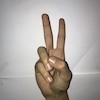

In [12]:
roses = list(data_dir.glob('two/*'))
PIL.Image.open(str(roses[0]))

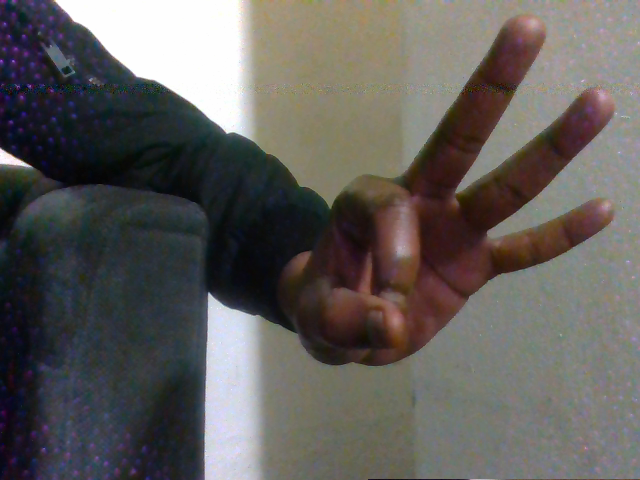

In [13]:
tulips = list(data_dir.glob('nine/*'))
PIL.Image.open(str(tulips[0]))

In [16]:
batch_size = 32
img_height = 180
img_width = 180

In [17]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2662 files belonging to 10 classes.
Using 2130 files for training.


2022-02-28 22:10:37.867858: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512F
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2662 files belonging to 10 classes.
Using 532 files for validation.


In [19]:
class_names = train_ds.class_names
print(class_names)

['eight', 'five', 'four', 'nine', 'one', 'seven', 'six', 'three', 'two', 'zero']


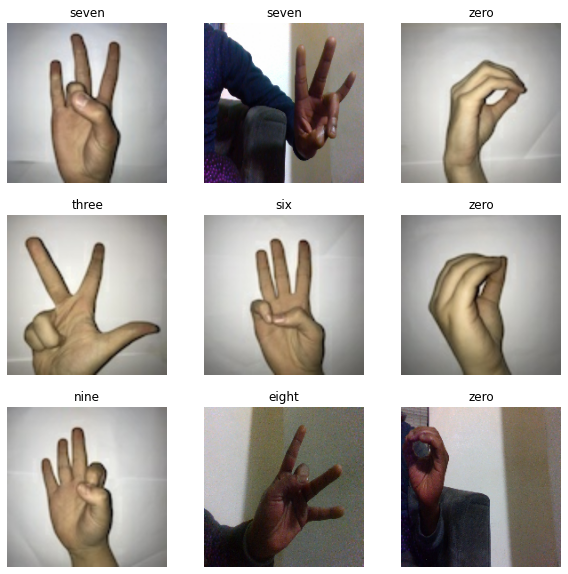

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [21]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [22]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [23]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [24]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 0.91343516


In [31]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

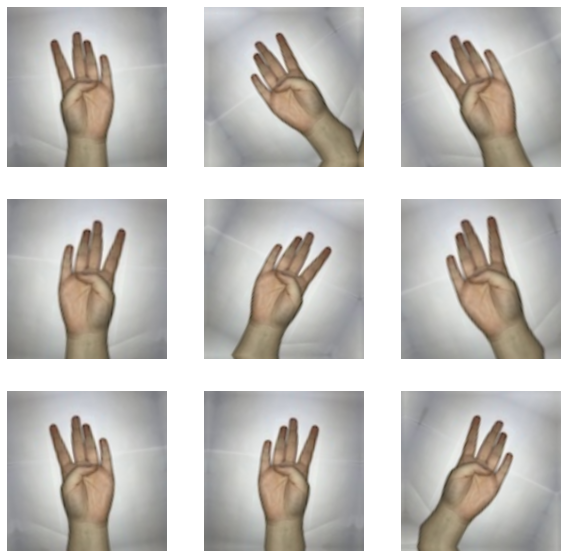

In [32]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [33]:
num_classes = 10

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [34]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [35]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
67/67 [==============================] - 8s 104ms/step - loss: 2.3170 - accuracy: 0.1169 - val_loss: 2.2554 - val_accuracy: 0.2105
Epoch 2/10
67/67 [==============================] - 6s 93ms/step - loss: 2.0780 - accuracy: 0.2629 - val_loss: 1.8424 - val_accuracy: 0.3064
Epoch 3/10
67/67 [==============================] - 6s 88ms/step - loss: 1.6483 - accuracy: 0.4333 - val_loss: 1.4046 - val_accuracy: 0.5188
Epoch 4/10
67/67 [==============================] - 6s 87ms/step - loss: 1.4354 - accuracy: 0.5080 - val_loss: 1.2922 - val_accuracy: 0.5583
Epoch 5/10
67/67 [==============================] - 6s 91ms/step - loss: 1.2373 - accuracy: 0.5831 - val_loss: 1.0687 - val_accuracy: 0.6485
Epoch 6/10
67/67 [==============================] - 7s 101ms/step - loss: 1.0674 - accuracy: 0.6343 - val_loss: 0.8156 - val_accuracy: 0.7312
Epoch 7/10
67/67 [==============================] - 6s 88ms/step - loss: 0.9307 - accuracy: 0.6869 - val_loss: 0.7266 - val_accuracy: 0.7444
Epoch 8/10


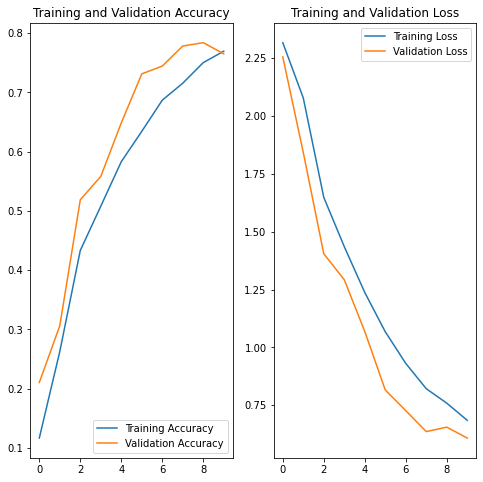

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [41]:
sunflower_url = "https://planetg.s3.amazonaws.com/7a_Color.png"
sunflower_path = tf.keras.utils.get_file('7a_Color', origin=sunflower_url)

img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

548864/536814 [==============================] - 0s 0us/step
This image most likely belongs to nine with a 94.71 percent confidence.
